<a href="https://colab.research.google.com/github/ElvisRojasM/Construction-of-Socioeconomic-Indicators-Using-Python/blob/main/1_Indice_de_confianza_en_instituciones_publicas_ENAHO_Modulo_85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indice de confianza en instituciones publicas - ENAHO Modulo 85

- El **Índice de Confianza** se construye utilizando datos de encuestas de varios años, enfocándose en la confianza pública en 16 instituciones diferentes. Para cada encuesta, las respuestas se categorizan según el nivel de confianza (por ejemplo, "suficiente", "bastante", "nada", "poco"). Estas categorías se convierten en variables binarias (1 para alta confianza, 0 para baja confianza) y se ponderan. Los promedios ponderados para cada institución se calculan a nivel municipal, y se deriva un índice de confianza promedio general al agregar estos promedios. Este índice cuantifica la confianza pública en diferentes instituciones a lo largo del tiempo.

In [ ]:
import pandas as pd
import numpy as np
import requests
from zipfile import ZipFile
from io import BytesIO

import matplotlib.pyplot as plt

import requests
from zipfile import ZipFile
from io import BytesIO

from functools import partial, reduce
import time
import requests
from io import StringIO

from google.colab import drive

In [ ]:
pip install pyreadstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 27.5 MB/s eta 0:00:00


In [ ]:
pip install geopandas

## Construccion de los indices

In [ ]:
def get_data_inei(zip_url,number_file):
    r         = requests.get(zip_url)
    z         = ZipFile(BytesIO(r.content))
    zipflies  = z.namelist()
    substr    = ['.csv', '.dta', '.sav']
    data_files  =[]
    for i in substr:
        for j in zipflies:
            if(j.find(i)!=-1 and j not in data_files):
                data_files.append(j)
    print('=====================================================================')
    [print(f'"{a}"') for a in data_files]
    print('=====================================================================')
    file_type  = data_files[number_file].split('.')[-1] ## identifica el tipo de file: sav, csv,  dta,
    rad        = z.extract(data_files[number_file])



    if file_type == 'sav':
        print(f'file type is ".{file_type}"')
        print('=====================================================================')
        df       = pd.read_spss(rad)
        print(f'successfully "{data_files[number_file]}" file read')
        print('=====================================================================')
    elif file_type == 'csv':
        print(f'file type is .{file_type}')
        print('=====================================================================')
        df       = pd.read_csv(rad,encoding= 'unicode_escape')
        print(f'successfully "{data_files[number_file]}" file read ')
        print('=====================================================================')
    elif file_type == 'dta':
        print(f'file type is .{file_type}')
        print('=====================================================================')
        df       = pd.read_stata(rad)
        print(f'successfully "{data_files[number_file]}" file read ')
        print('=====================================================================')
    return df

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
# https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/440-Modulo85.zip 2014
# https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/498-Modulo85.zip 2015
# https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/546-Modulo85.zip 2016
# https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/603-Modulo85.zip 2017
# https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/634-Modulo85.zip 2018
# https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/687-Modulo85.zip 2019
# https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/737-Modulo85.zip 2020
# https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/759-Modulo85.zip 2021
# https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/784-Modulo85.zip 2022
#https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/784-Modulo85.zip
# A la fecha (15-04-2023), los datos para el 2022 aun no estan disponibles.

In [ ]:
def weighted_groupby_describe(df, col, by, wt, frequency=False):
    '''
    df : dataframe
    col : column for which you want statistics, must be single column
    by : groupby column(s)
    wt : column to use for weights
    frequency : if True, use sample size as sum of weights (only effects degrees
    of freedom correction for unbiased variance)
    '''

    if isinstance(by, list):
        df = df.sort_values(by+[col])
    else:
        df = df.sort_values([by] + [col])

    newcols = ['gb_weights', 'col_weighted', 'col_mean',
        'col_sqdiff', 'col_sqdiff_weighted', 'gb_weights_cumsum', 'ngroup']
    assert all([c not in df.columns for c in newcols])

    df['gb_weights'] = df[wt]/df.groupby(by)[wt].transform('sum')

    df['gb_weights_cumsum'] = df.groupby(by)['gb_weights'].cumsum()

    df['col_weighted'] = df.eval('{}*gb_weights'.format(col))

    df['col_mean'] = df.groupby(by)['col_weighted'].transform('sum')

    df['col_sqdiff'] = df.eval('({}-col_mean)**2'.format(col))
    df['col_sqdiff_weighted'] = df.eval('col_sqdiff*gb_weights')

    wstd = df.groupby(by)['col_sqdiff_weighted'].sum()**(0.5)
    wstd.name = 'std'

    wmean = df.groupby(by)['col_weighted'].sum()
    wmean.name = 'mean'

    df['ngroup'] = df.groupby(by).ngroup()
    quantiles = np.array([0.25, 0.5, 0.75])
    weighted_quantiles = df['gb_weights_cumsum'] - 0.5*df['gb_weights'] + df['ngroup']
    ngroups = df['ngroup'].max()+1
    x = np.hstack([quantiles+i for i in range(ngroups)])
    quantvals = np.interp(x, weighted_quantiles, df[col])
    quantvals = np.reshape(quantvals, (ngroups, -1))

    other = df.groupby(by)[col].agg(['min', 'max', 'count'])

    stats = pd.concat([wmean, wstd, other], axis=1, sort=False)

    stats['25%'] = quantvals[:, 0]
    stats['50%'] = quantvals[:, 1]
    stats['75%'] = quantvals[:, 2]

    colorder = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    stats = stats[colorder]

    if frequency:
        sizes = df.groupby(by)[wt].sum()
    else:
        sizes = stats['count']

    stats['weight'] = sizes

    # use the "sample size" (weight) to obtain std. deviation from unbiased
    # variance
    stats['std'] = stats.eval('((std**2)*(weight/(weight-1)))**(1/2)')

    return stats

In [ ]:
survey_codes      = [ 440, 498, 546, 603, 634, 687, 737, 759, 784]
k                 = 2014
df_surveys_area   = {}
df_surveys_muni   = {}
institutions      = 16

identifiers = ['AÑO', 'MES', 'CONGLOME', 'VIVIENDA', 'HOGAR', 'CODPERSO', 'CODINFOR', 'UBIGEO', 'DOMINIO', 'ESTRATO']
quest       = ['P1_0' + str(x) for x in range(1,10)] + ['P1_' + str(x) for x in range(10,institutions+1)]

for i in survey_codes:
    link_inei = 'https://proyectos.inei.gob.pe/iinei/srienaho/descarga/STATA/' + str(i) + '-Modulo85.zip'
    df                = get_data_inei(link_inei, number_file = 0)

    df.columns        = df.columns.str.upper()
    if k == 2014:
      df                = df[identifiers + quest + ['FACGOB07']] # keep just with deseared variables
      df.rename(columns={'FACGOB07':'weigth', }, inplace=True)
    else:
      df                = df[identifiers + quest + ['FAMIEGOB07']] # keep just with deseared variables
      df.rename(columns={'FAMIEGOB07':'weigth', }, inplace=True)



    df_gp = []
    for quest_number, iQuest in zip(range(1,institutions+1), quest):
      print(f'INSTITUTION_{quest_number} and {iQuest}') ## A checker
      ## creating the dummy variable called "INSTITUTION_QUESTNUMBER"
      df.loc[ ( (df[f'{iQuest}'] == 'suficiente') | (df[f'{iQuest}'] == 'bastante') ), f'INSTITUTION_{str(quest_number)}'] = 1
      df.loc[ ( (df[f'{iQuest}'] == 'nada')       | (df[f'{iQuest}'] == 'poco')     ), f'INSTITUTION_{str(quest_number)}'] = 0
      df.loc[ ( (df[f'{iQuest}'] == 'no sabe')    | (df[f'{iQuest}'] ==  np.nan)    ), f'INSTITUTION_{str(quest_number)}'] = np.nan
      ## adding the average of the generated variable (a kind of confidence index by institution)
      #df_total1 = pd.merge(df, df[['DOMINIO', f'INSTITUTION_{str(quest_number)}']].groupby("DOMINIO").mean(numeric_only=True).reset_index() , how='left', on='DOMINIO', suffixes=('','_MEAN'))
      #df = pd.merge(df, df[['UBIGEO', f'INSTITUTION_{str(quest_number)}']].groupby("UBIGEO").mean( numeric_only=True).reset_index() , how='left', on='UBIGEO', suffixes=('','_MEAN') )
      #avoid get mean with nan values, by default numeric_only is true

      ### A nivel de municipalidades
      df_weigthed = weighted_groupby_describe(df.filter(regex= 'UBIGEO|weigth|' + f'INSTITUTION_{str(quest_number)}'), f'INSTITUTION_{str(quest_number)}', 'UBIGEO', 'weigth').reset_index()
      df_weigthed = df_weigthed[['UBIGEO','mean']]
      df_weigthed.columns = ['UBIGEO', f'INSTITUTION_{str(quest_number)}']

      df_gp.append(df_weigthed)

    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['UBIGEO'], how='outer'), df_gp)

    df_merged['AVERAGE_CONFIDENCE_INDEX'] = df_merged.filter(regex = 'INSTITUTION_').mean(axis=1, skipna=True, numeric_only=True )
    df_merged['AÑO'] = k
    cols = list(df_merged.filter(regex = 'INSTITUTION_'))
    #print(f'average over : { cols }')
    print(f' {k} year, done  \n  \n')
    #df_surveys_area[k]     = df_total1    # saving data in the diccionary for each year
    df_surveys_muni[k]     = df_merged    # saving data in the diccionary for each year
    k += 1

"440-Modulo85/enaho01b-2014-1.dta"
"440-Modulo85/enaho01b-2014-2.dta"
file type is .dta
successfully "440-Modulo85/enaho01b-2014-1.dta" file read 
INSTITUTION_1 and P1_01
INSTITUTION_2 and P1_02
INSTITUTION_3 and P1_03
INSTITUTION_4 and P1_04
INSTITUTION_5 and P1_05
INSTITUTION_6 and P1_06
INSTITUTION_7 and P1_07
INSTITUTION_8 and P1_08
INSTITUTION_9 and P1_09
INSTITUTION_10 and P1_10
INSTITUTION_11 and P1_11
INSTITUTION_12 and P1_12
INSTITUTION_13 and P1_13
INSTITUTION_14 and P1_14
INSTITUTION_15 and P1_15
INSTITUTION_16 and P1_16
 2014 year, completed  
  

"enaho01b-2015-1.dta"
"enaho01b-2015-2.dta"
file type is .dta
successfully "enaho01b-2015-1.dta" file read 
INSTITUTION_1 and P1_01
INSTITUTION_2 and P1_02
INSTITUTION_3 and P1_03
INSTITUTION_4 and P1_04
INSTITUTION_5 and P1_05
INSTITUTION_6 and P1_06
INSTITUTION_7 and P1_07
INSTITUTION_8 and P1_08
INSTITUTION_9 and P1_09
INSTITUTION_10 and P1_10
INSTITUTION_11 and P1_11
INSTITUTION_12 and P1_12
INSTITUTION_13 and P1_13
INSTITUTIO

In [ ]:
#'El Jurado Nacional de Elecciones- JNE'
#'La Oficina Nacional de Procesos Electorales- ONPE'
#'Registro Nacional de Identificación y Estado Civil-RENIEC'
#'La Municipalidad Provincial'
#'La Municipalidad Distrital'
#'La Policía Nacional del Perú'
#'Las Fuerzas Armadas'
#'El Gobierno Regional'
#'El Poder Judicial (Juzgados, Juez de Paz, etc.)'
#'El Ministerio de Educación (centros educativos, etc.)'
#'La Defensoría del Pueblo'
#'El Congreso de la República'
#'Los Partidos Políticos'
#'La Prensa Escrita'
#'La Radio o Televisión'
#'La Iglesia Católica'

In [ ]:
df_panel_muni = pd.concat(df_surveys_muni, axis =0).reset_index()
df_panel_muni.drop(['level_0','level_1'],axis=1,inplace=True)

df_panel_muni

,UBIGEO,INSTITUTION_1,INSTITUTION_2,INSTITUTION_3,INSTITUTION_4,INSTITUTION_5,INSTITUTION_6,INSTITUTION_7,INSTITUTION_8,INSTITUTION_9,INSTITUTION_10,INSTITUTION_11,INSTITUTION_12,INSTITUTION_13,INSTITUTION_14,INSTITUTION_15,INSTITUTION_16,AVERAGE_CONFIDENCE_INDEX,AÑO
0,010101,0.292414,0.347704,0.665314,0.345050,0.339757,0.221264,0.337490,0.164322,0.179305,0.469186,0.300797,0.122650,0.009355,0.189385,0.355127,0.619804,0.309933,2014
1,010102,0.214327,0.142904,0.142904,0.000000,0.000000,0.428520,0.428520,0.428520,0.357096,0.000000,0.142904,0.000000,0.357096,0.000000,0.357096,0.499933,0.218739,2014
2,010103,0.123427,0.258313,0.595435,0.325662,0.527992,0.662784,0.662784,0.325662,0.202236,0.797671,0.662784,0.000000,0.000000,0.123427,0.134886,0.123427,0.345406,2014
3,010109,0.229778,0.353641,0.628164,0.299283,0.333681,0.322439,0.240379,0.300093,0.240108,0.674380,0.472644,0.163619,0.127567,0.283261,0.404708,0.644309,0.357378,2014
4,010110,0.195536,0.215319,0.537265,0.204252,0.200755,0.262947,0.333398,0.092418,0.090735,0.377475,0.131988,0.033034,0.033034,0.110530,0.087247,0.553051,0.216186,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11190,250301,0.151551,0.207872,0.518092,0.038138,0.067444,0.146999,0.435460,0.065005,0.162958,0.463616,0.219040,0.038097,0.017509,0.068125,0.060885,0.308060,0.185553,2022
11191,250302,0.056471,0.131511,0.500206,0.140189,0.139605,0.108873,0.327402,0.102110,0.207811,0.489935,0.227488,0.085447,0.041230,0.019580,0.118458,0.271704,0.185501,2022
11192,250303,0.203743,0.123770,0.486765,0.178732,0.195971,0.263161,0.550555,0.346511,0.325746,0.578864,0.269197,0.179062,0.039717,0.234580,0.216981,0.476085,0.291840,2022
11193,250304,0.047279,0.189855,0.621948,0.023765,0.085802,0.129199,0.683773,0.132265,0.197185,0.523481,0.354183,0.085552,0.000000,0.179310,0.354772,0.079749,0.230507,2022


## Reportes estadisticos : Graficos - tablas

In [ ]:
import geopandas as gpd
url  = "https://raw.githubusercontent.com/juaneladio/peru-geojson/master/peru_distrital_simple.geojson"
mapa_coordinates = gpd.read_file(url)

In [ ]:
df_map = pd.merge(mapa_coordinates, df_panel_muni, left_on = 'IDDIST', right_on='UBIGEO' )

In [ ]:
num_year = list(df_map.AÑO.value_counts().index)
num_year, len(num_year)

([2018, 2017, 2019, 2016, 2021, 2022, 2015, 2020, 2014], 9)

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

## Indice de confianza de todas las instituciones: promedio

0-1-2-3-4-5-6-7-8-

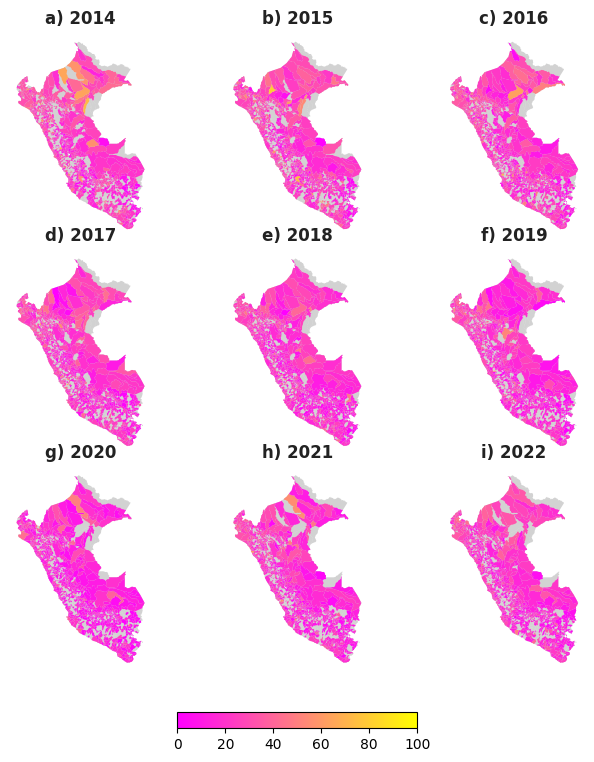

In [ ]:
# Obtener el total de años
total_year      = len(df_map.AÑO.value_counts().index)
institution_num ='AVERAGE_CONFIDENCE_INDEX'
# Graficar los mapas
iyear = 2014
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.05, wspace=0.05, top=0.9, bottom=0.1, left=0.1, right=0.9)  # Ajustar los espacios en blanco

axs = axs.flatten()
items = [chr(value) for value in range(97, 97+total_year)]

for ii in range(len(num_year)):
  ax = axs[ii]
  df_year = df_map[df_map.AÑO==iyear]
  mapa_coordinates.plot(ax=ax, alpha=0.35, color="grey")
  df_year.plot(column= institution_num , categorical=False, vmin=0, vmax=1, ax=ax, cmap=plt.cm.spring,
                legend=False, legend_kwds={'orientation': 'horizontal', 'pad': 0.02})
  ax.axis('off')
  ax.set_title(items[ii] + ') ' + str(iyear), fontsize=12, fontname='sans-serif', fontweight='bold', color='#222222')

  legend_axis = ax.figure.axes[ii]
  for label in legend_axis.get_xticklabels():
    label.set_fontproperties({'family': 'sans-serif', 'weight': 300, 'size': 8})
    label.set_color('#222222')
  iyear += 1
  print(ii, end="-")


mappable = cm.ScalarMappable(norm=mcolors.Normalize(0,100), cmap=plt.cm.spring)
cb_ax = fig.add_axes([0.35, 0.03, 0.3, 0.02])  # Modificar las coordenadas de la leyenda
cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')

plt.show()  # Blues_r, autumn_r


In [ ]:
#1  . 'El Jurado Nacional de Elecciones- JNE'
#2  . 'La Oficina Nacional de Procesos Electorales- ONPE'
#3  . 'Registro Nacional de Identificación y Estado Civil-RENIEC'
#4  . 'La Municipalidad Provincial'
#5  . 'La Municipalidad Distrital'
#6  . 'La Policía Nacional del Perú'
#7  . 'Las Fuerzas Armadas'
#8  . 'El Gobierno Regional'
#9  . 'El Poder Judicial (Juzgados, Juez de Paz, etc.)'
#10 . 'El Ministerio de Educación (centros educativos, etc.)'
#11 . 'La Defensoría del Pueblo'
#12 . 'El Congreso de la República'
#13 . 'Los Partidos Políticos'
#14 . 'La Prensa Escrita'
#15 . 'La Radio o Televisión'
#16 . 'La Iglesia Católica'

## Indice de confianza para el congreso de la republica

0-1-2-3-4-5-6-7-8-

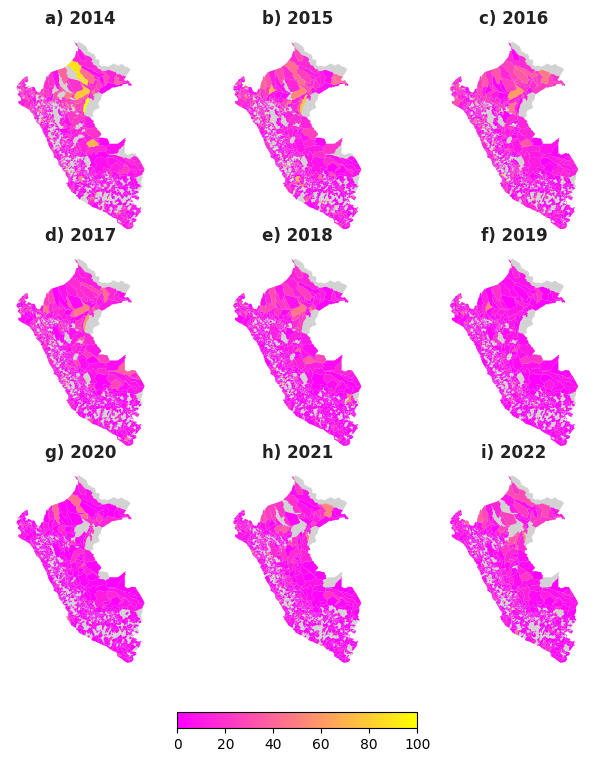

In [ ]:

iyear = 2014;
institution_num = 12 #12 . 'El Congreso de la República'

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.05, wspace=0.05, top=0.9, bottom=0.1, left=0.1, right=0.9)  # Ajustar los espacios en blanco
axs = axs.flatten()

for ii in range(len(num_year)):
  ax = axs[ii]
  df_year = df_map[df_map.AÑO==iyear]
  mapa_coordinates.plot(ax=ax, alpha=0.35, color= "grey")
  df_year.plot(column='INSTITUTION_' + str(institution_num) ,  categorical=False, vmin=0, vmax=1, ax=ax, cmap=plt.cm.spring,
                legend=False, legend_kwds={'orientation': 'horizontal', 'pad': 0.02}, )
  ax.axis('off')
  ax.set_title( items[ii] + ') ' + str(iyear), fontsize=12, fontname='sans-serif', fontweight='bold', color='#222222')

  legend_axis = ax.figure.axes[ii]
  for label in legend_axis.get_xticklabels():
    label.set_fontproperties({'family': 'sans-serif', 'weight': 300, 'size': 8})
    label.set_color('#222222')
  iyear += 1
  print(ii,end='-')

mappable = cm.ScalarMappable(norm=mcolors.Normalize(0,100), cmap=plt.cm.spring)
cb_ax = fig.add_axes([0.35, 0.03, 0.3, 0.02])  # Modificar las coordenadas de la leyenda
cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')

plt.show()

## Indice de confianza para el poder judical

0-1-2-3-4-5-6-7-8-

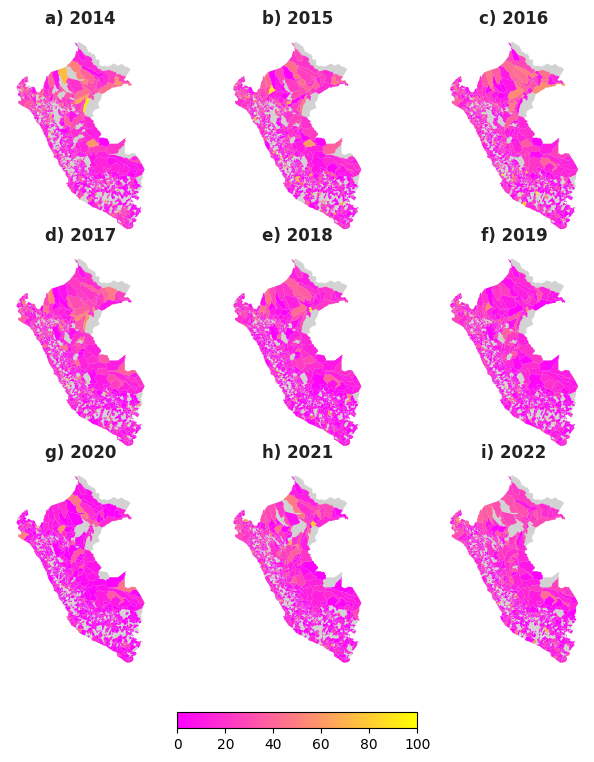

In [ ]:
iyear           = 2014;
institution_num = 9  #9  . 'El Poder Judicial (Juzgados, Juez de Paz, etc.)'

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
fig.subplots_adjust(hspace=0.05, wspace=0.05, top=0.9, bottom=0.1, left=0.1, right=0.9)  # Ajustar los espacios en blanco
axs = axs.flatten()


for ii in range(len(num_year)):
  ax = axs[ii]
  df_year = df_map[df_map.AÑO==iyear]
  mapa_coordinates.plot(ax=ax, alpha=0.35, color= "grey")
  df_year.plot(column='INSTITUTION_' + str(institution_num) ,  categorical=False, vmin=0, vmax=1, ax=ax, cmap=plt.cm.spring,
                legend=False, legend_kwds={'orientation': 'horizontal', 'pad': 0.02}, )
  ax.axis('off')
  ax.set_title( items[ii] + ') ' + str(iyear), fontsize=12, fontname='sans-serif', fontweight='bold', color='#222222')
  iyear += 1
  print(ii,end='-')

mappable = cm.ScalarMappable(norm=mcolors.Normalize(0,100), cmap=plt.cm.spring)
cb_ax = fig.add_axes([0.35, 0.03, 0.3, 0.02])  # Modificar las coordenadas de la leyenda
cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal')

plt.show() #Blues_r , autumn_r


## Evolucion temporal de los indices de confianza

In [ ]:
## build stats
years_conf_ind        = df_panel_muni.filter(regex='AVERAGE_CONFIDENCE_INDEX|INSTITUTION_|AÑO').groupby(by='AÑO').mean().reset_index()
years_conf_ind.index = years_conf_ind.AÑO
years_conf_ind.drop('AÑO',axis=1, inplace=True)
plots  = years_conf_ind.filter(regex='AVERAGE|9|12')
plots  = plots[['AVERAGE_CONFIDENCE_INDEX','INSTITUTION_9','INSTITUTION_12']]


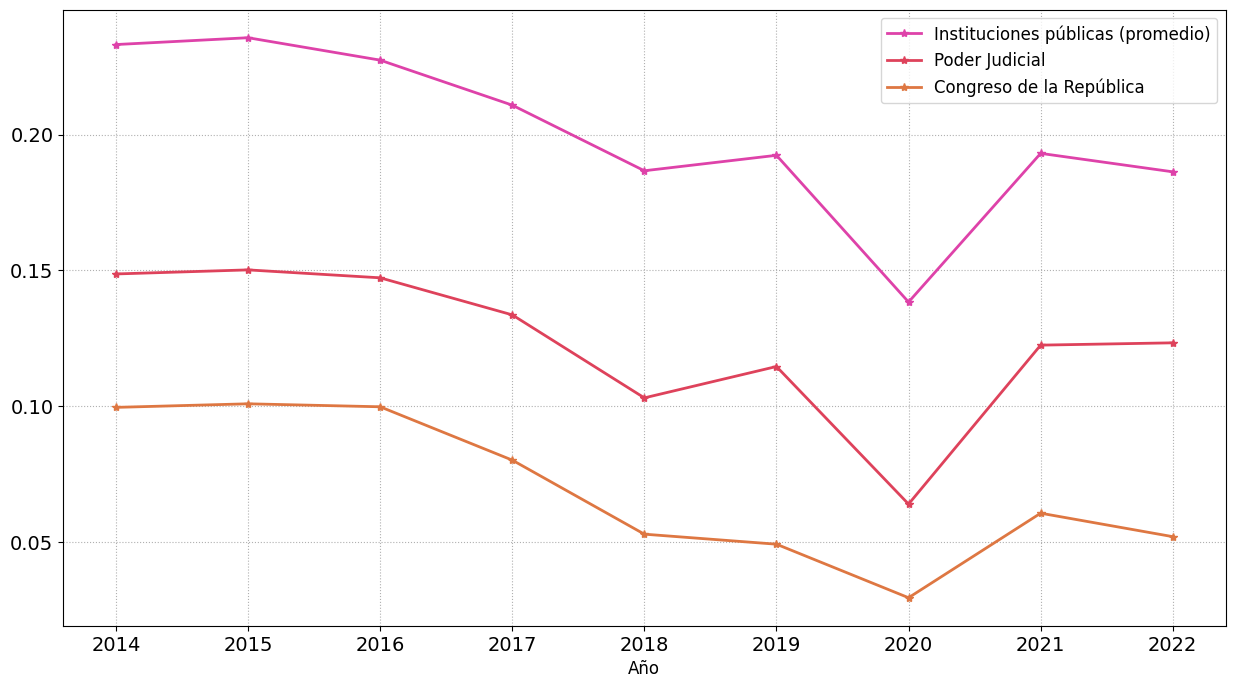

In [ ]:
### Figura
labels = ['Instituciones públicas (promedio)', 'Poder Judicial', 'Congreso de la República']
colors = ['#de42a9', '#de425b', '#de7742']
fig, ax = plt.subplots(1,1,figsize=(15,8))
for ii,jj in zip(plots,range(3)):
  ax.plot(plots[ii],label=labels[jj], linewidth = 2, marker='*', color=colors[jj])
  ax.grid(linestyle=':'); ax.xaxis.set_tick_params(labelsize=14);   ax.yaxis.set_tick_params(labelsize=14)
  ax.set_xlabel('Año', fontsize=12)

plt.legend(fontsize=12)
plt.show()